# 0. General Imports and Definitions

## 0.1 Python Imports 

In [1]:
import numpy as np
# for new l1q style
from __future__ import annotations

# convenience import for all LabOne Q software functionality
from laboneq.simple import *
from laboneq.dsl.experiment.builtins import *
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation, plot_results
# for logging
import logging
# connect to VNA as LO source
from helpers.customized_drivers.Rohde_Schwarz_ZNA26 import (
    RohdeSchwarzZNA26,
)
# vna = RohdeSchwarzZNA26('VNA',
#                             vna_IP,
#                             init_s_params=False,
#                             reset_channels=False,
#                             )
# chan = RohdeSchwarzZNBChannel(
#             vna,
#             name="S21",
#             channel=1,
#             vna_parameter="S21",
#             existing_trace_to_bind_to="Trc1",
#         )
# vna.channels.append(chan)
# # vna.add_channel('S21')
# vna.cont_meas_on()
# vna.display_single_window()
# vna.channels.S21.power.set(-50) # for safety


from qcodes_contrib_drivers.drivers.SignalCore.SignalCore import SC5521A
sc = SC5521A('mw1')
sc.power(-10) # for safety
sc.status("off")
sc.clock_frequency(10)

Connected to: SignalCore SC5521A (serial:268450462, firmware:4.199999809265137) in 0.03s


Prepare standard setup

In [2]:
#host="10.42.11.x"
host="localhost"
# host="qt-labonefarm-demo.zhinst.com"
    
# create
setup = DeviceSetup("support_setup")

# number of qubits

# add a dataserver
setup.add_dataserver(host=host, port=8004)
# add an SHFSG
setup.add_instruments(
    HDAWG(uid="device_hdawg", address="dev9131", device_options="HDAWG8"),
    PQSC( uid="device_pqsc", address="dev10219", reference_clock_source='internal'),
    SHFQC(uid="device_shfqc", address="DEV12551", device_options="SHFQC/PLUS/QC2CH")
    )

# add connections
## SHFQC
setup.add_connections(
    "device_shfqc",
    create_connection(to_signal="q0/drive", ports=f"SGCHANNELS/0/OUTPUT"),
    create_connection(to_signal="q0/drive_ef", ports=f"SGCHANNELS/0/OUTPUT"),
    create_connection(to_signal="q0/measure", ports=f"QACHANNELS/0/OUTPUT"),
    create_connection(to_signal="q0/acquire", ports=f"QACHANNELS/0/INPUT"),
    create_connection(to_signal="q1/drive", ports=f"SGCHANNELS/1/OUTPUT"),
    create_connection(to_signal="q1/drive_ef", ports=f"SGCHANNELS/1/OUTPUT"),
    create_connection(to_signal="q1/measure", ports=f"QACHANNELS/0/OUTPUT"),
    create_connection(to_signal="q1/acquire", ports=f"QACHANNELS/0/INPUT"),
)
## PQSC (Seacucumber connections)
setup.add_connections(
    "device_pqsc",
    create_connection(to_instrument="device_shfqc", ports="ZSYNCS/0"),
    create_connection(to_instrument="device_hdawg", ports="ZSYNCS/1"),
)
## HDAWG
setup.add_connections(
    "device_hdawg",
    create_connection(to_signal="q0/flux", ports="SIGOUTS/0"),
    create_connection(to_signal="q1/flux", ports="SIGOUTS/1"),
    create_connection(to_signal="q2/flux", ports="SIGOUTS/2"),
    #create_connection(to_signal="q0/drive_line", ports=["SIGOUTS/0","SIGOUTS/1"]),
)

Generate descriptor needed for L1Q

In [3]:
# SHORTCUTS
## shortcute to connections
drive_lsg   = setup.logical_signal_groups["q0"].logical_signals["drive"]
measure_lsg = setup.logical_signal_groups["q0"].logical_signals["measure"]
acquire_lsg = setup.logical_signal_groups["q0"].logical_signals["acquire"]
flux_lsg    = setup.logical_signal_groups["q0"].logical_signals["flux"]
## shortcut to ExperimentalSignal
def create_signals(qubit_list = ["q0"], types = ["drive", "measure", "acquire", "flux"]):
    signals = []
    for q in qubit_list:
        for type in types:
            lsl = setup.logical_signal_groups[q].logical_signals[type]
            signals.append(ExperimentSignal(type, map_to=lsl))
            
    return signals            

# 1. Define the Device Setup and apply baseline calibration

We'll load a descriptor file to define our device setup and logical signal lines and then apply a baseline calibration to the signal lines based on a dictionary of qubit parameters

In [5]:
param_dict = {
    "ro_freq":3.08e9, # [Hz] SHFQC output frequenc2.6
    "ro_lo_freq":2.6e9, # ro_if_freq = ro_freq-ro_lo_freq
    "ro_pulse_length":2e-6, #[sec]
    "ro_power":3, # [dBm] ZInstrument output power
    "ro_acquire_range":-30,
    
    # external LO source (Signal core)
    "ro_exLO_freq":17.312e9,#17.392e9-0.0e9, # This freq cannot be detuned by more than 500MHz from "ro_freq"
    "ro_exLO_power":15, # [dBm]
    
    "qu_freq": 4675280000,
    "qu_lo_freq":4.4e9, #[GHz]
    "qu_pi_pulse_length":35e-9,
    "qu_power":9.55,
    
    "ef_freq":4.4236e9,
    "ef_pulse_length":19e-6,
    # "ef_lo_freq":5.6e9, # cannot use different lo freq for the same output line!
    "ef_drive_power":9.55, # maybe need to be lower than "qu_power"(second tone). need to be fixed.
    
    "current":0e-3, # [A]
}

In [6]:
sc.status('on')
sc.power(param_dict["ro_exLO_power"])
sc.frequency(param_dict["ro_exLO_freq"])

In [7]:
def shfqa_power_calculator(ro_power):
    """
    calculate oscillator power range and pulse amplitude
    to get the correct output power for SHFQA out port
    "amp" should must be lower than 0.95 not to overload power range!!
    
    ro_power = 20 * np.log10(pulse_amp) + power_range
    """
    prange_list=np.linspace(-30, 10, 9)
    if ro_power > 20*np.log10(0.95) + 10:
        raise ValueError(f'The maximum power of SHFQC is {20*np.log10(0.95) + 10} dBm!')
    for prange in prange_list:
        if ro_power <= 20*np.log10(0.95) + prange:
            power_range=prange
            signal_amp=10**((ro_power-power_range)/20)
            break
    return power_range, signal_amp
qu_range, qu_amp = shfqa_power_calculator(param_dict["qu_power"])
ro_range, ro_amp = shfqa_power_calculator(param_dict["ro_power"])

# simple calibration
drive_lsg.calibration      = SignalCalibration()
drive_lsg.local_oscillator = Oscillator("lo_osc", frequency=param_dict["qu_lo_freq"])
drive_lsg.oscillator       = Oscillator("sc",    frequency=param_dict["qu_freq"]-param_dict["qu_lo_freq"], modulation_type=ModulationType.HARDWARE)
drive_lsg.port_mode        = PortMode.RF
drive_lsg.range            = qu_range #dBm
## measure
lo_qa = Oscillator(uid="lo_qa", frequency=param_dict["ro_lo_freq"])
o_qa  = Oscillator(uid="o_qa",  frequency=param_dict["ro_freq"]-param_dict["ro_lo_freq"], modulation_type=ModulationType.HARDWARE)
measure_lsg.calibration      = SignalCalibration()
measure_lsg.local_oscillator = lo_qa
#measure_lsg.oscillator       = measure_osc
measure_lsg.oscillator       = o_qa
measure_lsg.port_mode        = PortMode.RF

measure_lsg.range            =ro_range #dBm
## acquire
acquire_lsg.calibration      = SignalCalibration()
acquire_lsg.local_oscillator = lo_qa
#acquire_lsg.oscillator       = acquire_osc
acquire_lsg.oscillator       = o_qa
acquire_lsg.port_mode        = PortMode.RF
acquire_lsg.range            = param_dict["ro_acquire_range"] #dBm
## flux
flux_lsg.calibration      = SignalCalibration()
flux_lsg.oscillator       = Oscillator(uid="flux_osc", frequency=0)
flux_lsg.range            = 5 #Volt

We can finally define one session

In [8]:
session = Session(device_setup=setup, log_level=logging.INFO)
session.connect(do_emulation=False)

[2025.01.24 16:32:36.018] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is Z:\Projects\HighTempFluxonium\Measurement\measurement_codes\laboneq_output\log
[2025.01.24 16:32:36.025] INFO    VERSION: laboneq 2.43.0
[2025.01.24 16:32:36.028] INFO    Connecting to data server at localhost:8004
[2025.01.24 16:32:36.047] INFO    Connected to Zurich Instruments LabOne Data Server version 24.10 at localhost:8004
[2025.01.24 16:32:36.311] INFO    Configuring the device setup
[2025.01.24 16:32:36.878] INFO    The device setup is configured


First in near time, should always work if single length fit in the memory

In [9]:
@experiment(signals=create_signals())
def exp(
        drive_pulse   = pulse_library.gaussian_square(
                                    uid="qu_pulse",
                                    length=param_dict["qu_pi_pulse_length"]+20e-9,
                                    width=param_dict["qu_pi_pulse_length"],
                                    amplitude=qu_amp,
                                ),
        measure_pulse = pulse_library.const(length=param_dict["ro_pulse_length"],amplitude=ro_amp),
        ):

    with acquire_loop_rt(
        count=5000,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        ):
        
        for amplitude in [0., 1.0]:
            
            with section():
                play("drive", drive_pulse, amplitude=amplitude)
                
            with section():
                reserve("drive")
                measure(
                    measure_signal="measure",
                    acquire_signal="acquire",
                    handle=f"state_{int(amplitude)}",
                    measure_pulse=measure_pulse,
                    integration_kernel=measure_pulse,
                    reset_delay=3*40e-6,
                )
            
    # experiment calibration
    cal = experiment_calibration()
    cal["drive"]   = SignalCalibration()    
    cal["measure"] = SignalCalibration()
    cal["acquire"] = SignalCalibration()    

In [10]:
cexp = session.compile(exp())

result = session.run(cexp)

[2025.01.24 16:32:38.443] INFO    Resolved modulation type of oscillator 'flux_osc' on signal 'flux' to HARDWARE
[2025.01.24 16:32:38.445] INFO    Starting LabOne Q Compiler run...
[2025.01.24 16:32:38.449] INFO    Schedule completed. [0.001 s]
[2025.01.24 16:32:38.461] INFO    Code generation completed for all AWGs. [0.011 s]
[2025.01.24 16:32:38.463] INFO    Completed compilation step 1 of 1. [0.015 s]
[2025.01.24 16:32:38.469] INFO     ───────────────────────────────────────────────────────────────────── 
[2025.01.24 16:32:38.470] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2025.01.24 16:32:38.472] INFO     ───────────────────────────────────────────────────────────────────── 
[2025.01.24 16:32:38.473] INFO      device_hdawg        0          4            1           0         0  
[2025.01.24 16:32:38.475] INFO      device_shfqc        0         12            0           1      8000  
[2025.01.24 16:32:38.476] INFO      device_shfqc_sg     0     

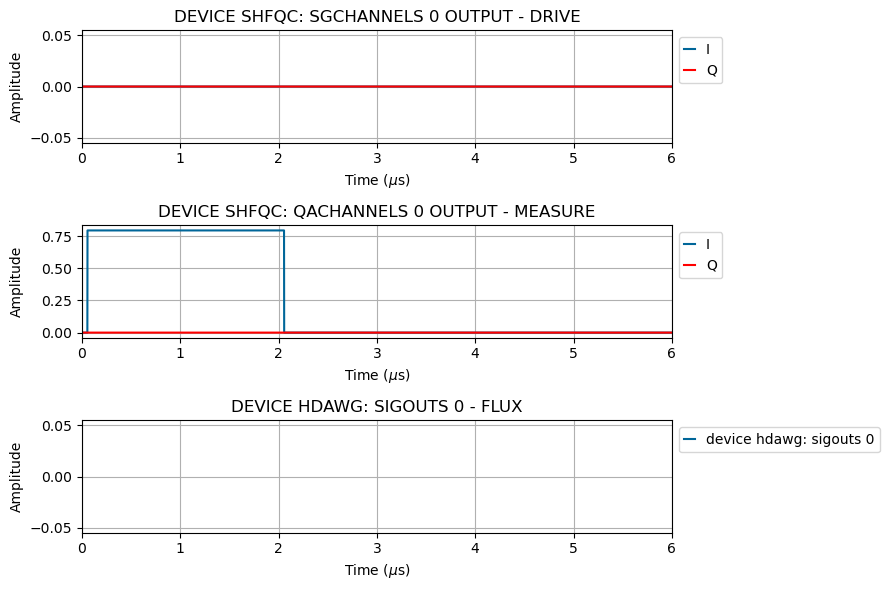

In [11]:
plot_simulation(cexp,
                length=6e-6,
                )

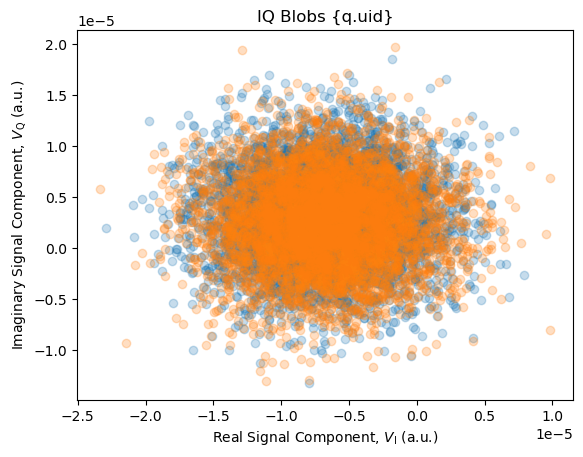

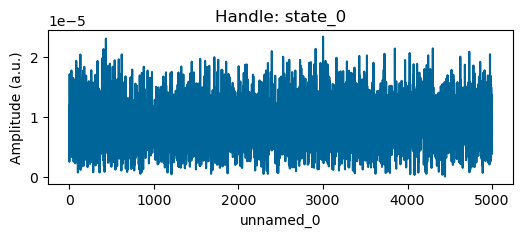

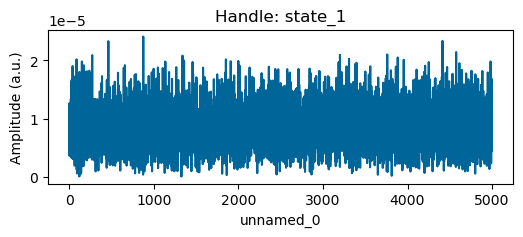

In [12]:
import matplotlib.pyplot as plt
# IQ blobs
state0 = result.get_data("state_0")
state1 = result.get_data("state_1")

fig, ax = plt.subplots()
ax.set_title("IQ Blobs {q.uid}")
ax.set_xlabel("Real Signal Component, $V_{\\mathrm{I}}$ (a.u.)")
ax.set_ylabel("Imaginary Signal Component, $V_{\\mathrm{Q}}$ (a.u.)")
ax.scatter(
            state0.real,
            state0.imag,
            c="C0",
            alpha=0.25,
            label="ground",
            )
ax.scatter(
            state1.real,
            state1.imag,
            c="C1",
            alpha=0.25,
            label="excited",
            )


plot_results(result)

State0: -6.851381386305888e-06 1j 3.060239750639609e-06
State1: -6.648834730277622e-06 1j 2.5787762005206227e-06


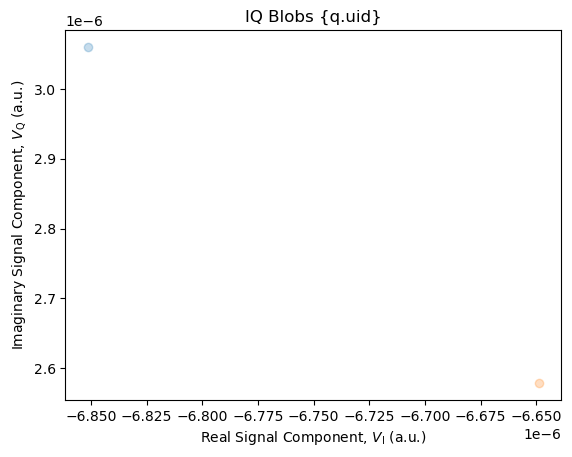

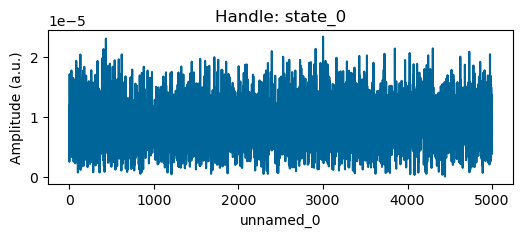

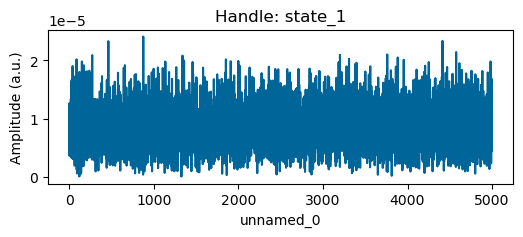

In [17]:
import matplotlib.pyplot as plt
# IQ blobs
state0 = result.get_data("state_0")
state1 = result.get_data("state_1")

fig, ax = plt.subplots()
ax.set_title("IQ Blobs {q.uid}")
ax.set_xlabel("Real Signal Component, $V_{\\mathrm{I}}$ (a.u.)")
ax.set_ylabel("Imaginary Signal Component, $V_{\\mathrm{Q}}$ (a.u.)")
ax.scatter(
            np.mean(state0.real),
            np.mean(state0.imag),
            c="C0",
            alpha=0.25,
            label="ground",
            )
ax.scatter(
            np.mean(state1.real),
            np.mean(state1.imag),
            c="C1",
            alpha=0.25,
            label="excited",
            )

print("State0:",np.mean(state0.real),"1j",np.mean(state0.imag))
print("State1:",np.mean(state1.real),"1j",np.mean(state1.imag))
plot_results(result)